# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to ask: “do these datasets have similar patterns”?

To do this we will use a visual inspection using PCA

**Approach:**
1. Given Dataset A = simulated data with everything in 1 batch and Dataset B = simulated data with X batches, where X = 1,2,3,....
2. Plot PC1 vs PC2 of combined dataset A + B
3. Color samples by whether they are from A or B
4. Visually inspect the overlap between A and B

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import *
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Load config file
config_file = "config_exp_2.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

Plotting PCA of 1 batch vs 1 batches...


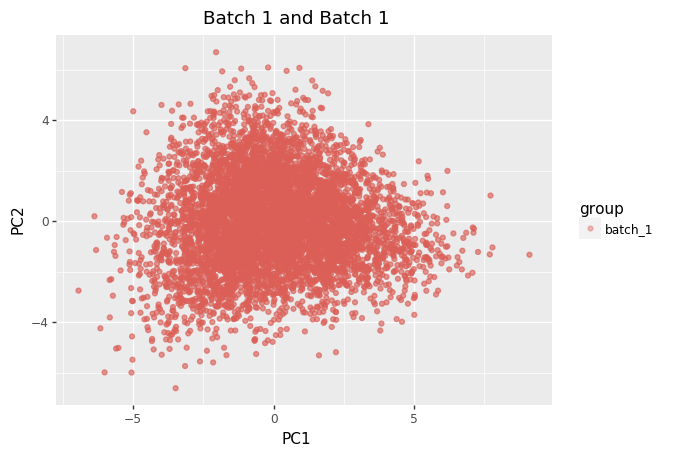

<ggplot: (-9223363245682335165)>
Plotting PCA of 1 batch vs 2 batches...


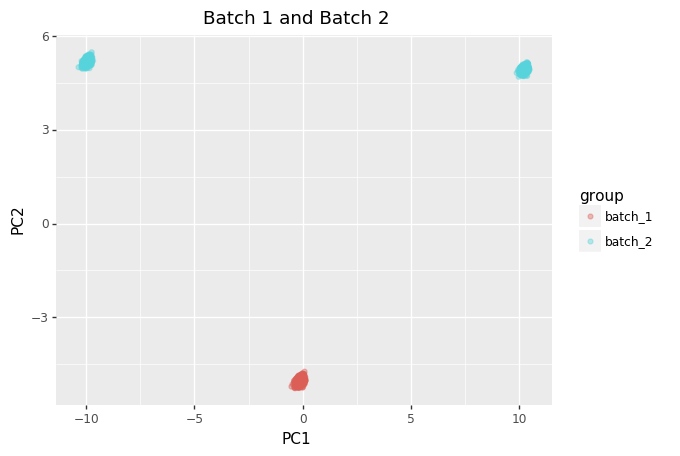

<ggplot: (-9223363245683025527)>
Plotting PCA of 1 batch vs 5 batches...


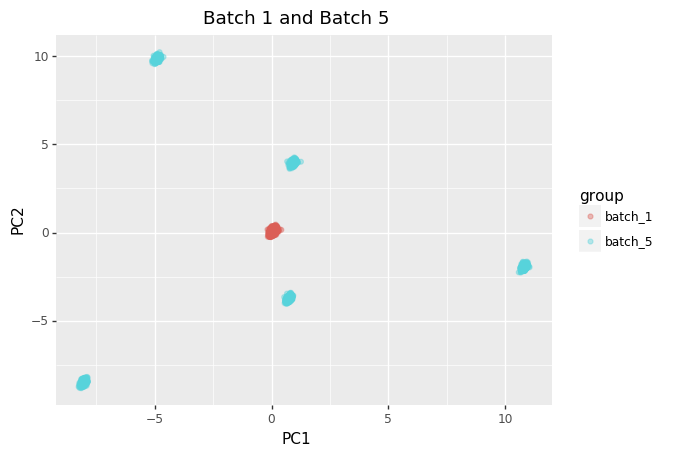

<ggplot: (-9223363245683276435)>
Plotting PCA of 1 batch vs 10 batches...


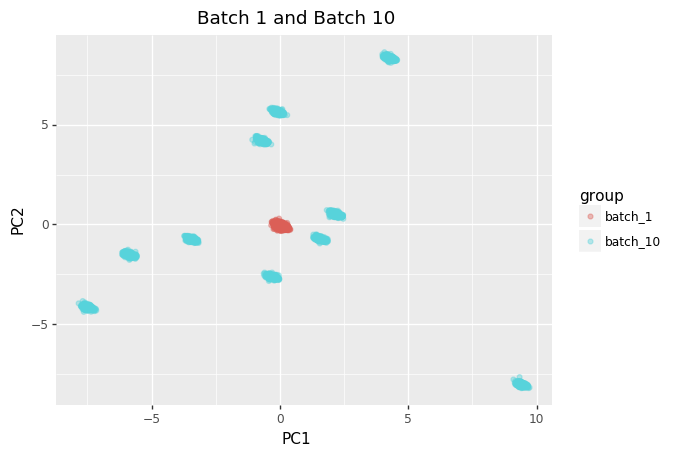

<ggplot: (8791216095394)>
Plotting PCA of 1 batch vs 20 batches...


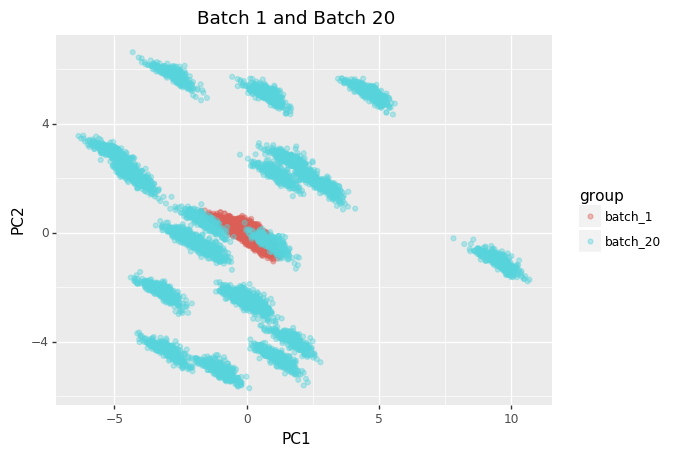

<ggplot: (8791169219581)>
Plotting PCA of 1 batch vs 50 batches...


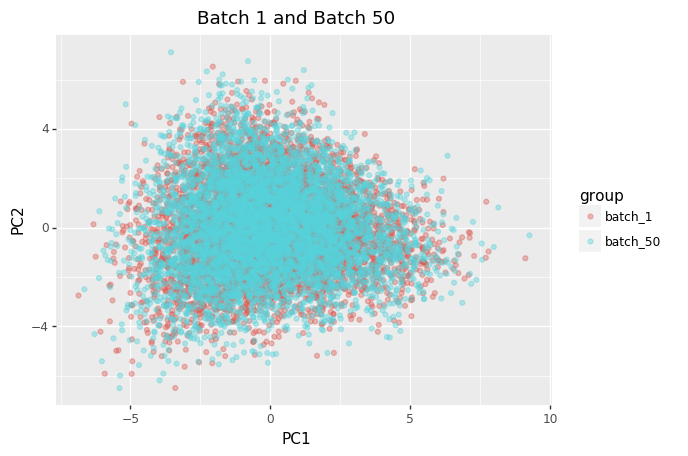

<ggplot: (-9223363245682563356)>
Plotting PCA of 1 batch vs 100 batches...


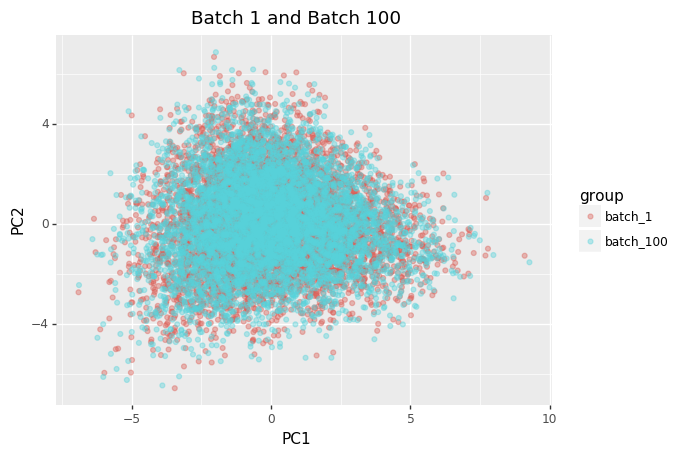

<ggplot: (8791167899235)>
Plotting PCA of 1 batch vs 500 batches...


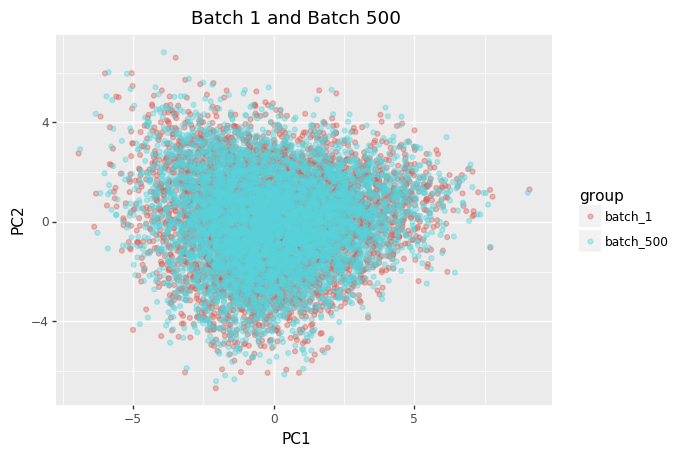

<ggplot: (8791167780900)>
Plotting PCA of 1 batch vs 1000 batches...


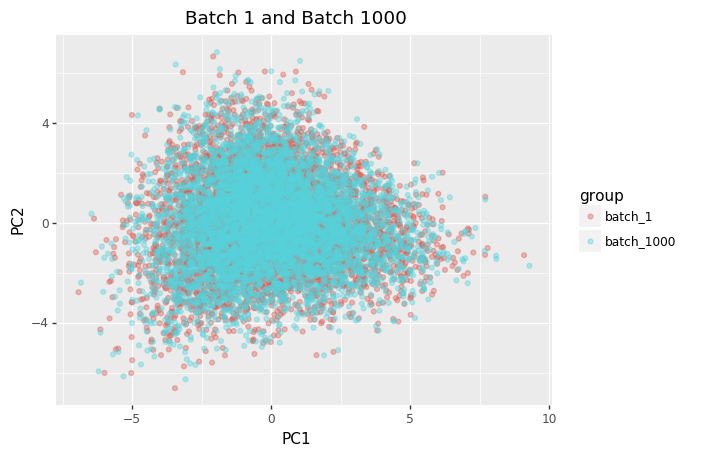

<ggplot: (-9223363245638714108)>
Plotting PCA of 1 batch vs 2000 batches...


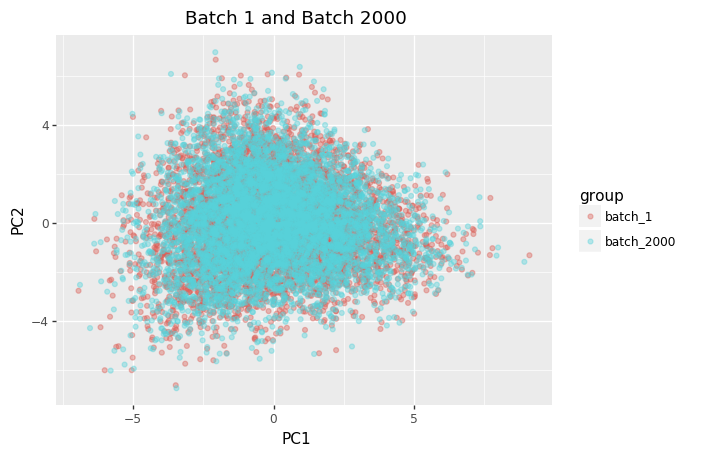

<ggplot: (8791172222493)>
Plotting PCA of 1 batch vs 3000 batches...


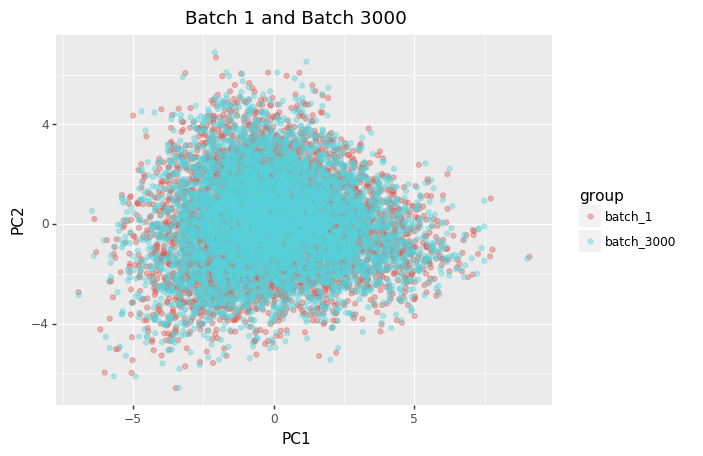

<ggplot: (-9223363245682504199)>
Plotting PCA of 1 batch vs 6000 batches...


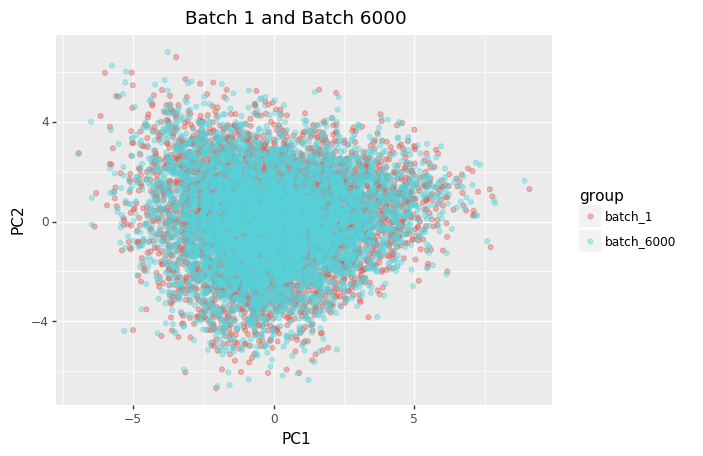

<ggplot: (-9223363245683175301)>
CPU times: user 7min 39s, sys: 53.1 s, total: 8min 32s
Wall time: 7min 5s


In [5]:
%%time

all_data_df = pd.DataFrame()

for i in num_batches:
    print('Plotting PCA of 1 batch vs {} batches...'.format(i))
    
    # Get batch 1 data
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        index_col=0,
        sep='\t')

    # Simulated data with all samples in a single batch
    original_data_df =  batch_1.copy()
    
    # Add grouping column for plotting
    original_data_df['group'] = 'batch_1'
    
    # Get data with additional batch effects added
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    batch_data_df =  batch_other
    
    # Add grouping column for plotting
    batch_data_df['group'] = "batch_{}".format(i)
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, batch_data_df])
    
    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['group'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['group'] = combined_data_df['group']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['num_batches'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])
    
    
    # Plot individual comparisons
    print(ggplot(combined_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
          + geom_point(aes(color='group'), alpha=0.4) \
          + xlab('PC1') \
          + ylab('PC2') \
          + ggtitle('Batch 1 and Batch {}'.format(i))
         )

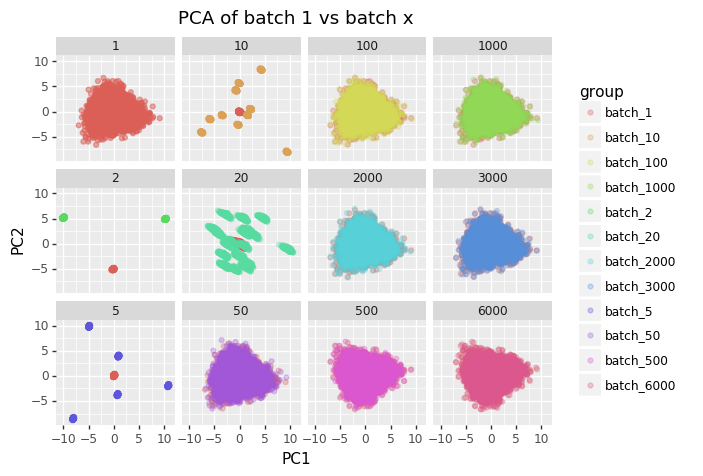

<ggplot: (-9223363245682339342)>

In [6]:
# Plot all comparisons in one figure
ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='group'), alpha=0.3) \
+ facet_wrap('~num_batches') \
+ xlab('PC1') \
+ ylab('PC2') \
+ ggtitle('PCA of batch 1 vs batch x')

## Permuted dataset (Negative control)

As a negative control we will permute the values within a sample, across genes in order to disrupt the gene expression structure.

In [7]:
# Permute simulated data
shuffled_simulated_arr = []
num_samples = batch_1.shape[0]

for i in range(num_samples):
    row = list(batch_1.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, 
                                       index=batch_1.index,
                                       columns=batch_1.columns)
shuffled_simulated_data.head()

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2787,2526,3299,3097,5330,2854,494,5089,3662,1920
0,0.588697,0.361900,0.184515,0.503013,0.166644,0.296235,0.641898,0.776261,0.578701,0.336616,...,0.395170,0.339693,0.068221,0.313933,0.247299,0.319965,0.326767,0.391811,0.554803,0.121577
1,0.285519,0.283531,0.387318,0.241697,0.335380,0.514705,0.159144,0.223517,0.269023,0.331519,...,0.591331,0.210320,0.244849,0.491987,0.655464,0.198530,0.203814,0.507510,0.667491,0.230053
2,0.423079,0.158008,0.619630,0.382724,0.439609,0.125574,0.493919,0.294091,0.219538,0.213207,...,0.403598,0.394981,0.104890,0.311528,0.799130,0.541422,0.102494,0.312107,0.143166,0.241600
3,0.301855,0.490190,0.447995,0.457465,0.540753,0.471507,0.469329,0.343756,0.433110,0.430258,...,0.247550,0.410010,0.165511,0.328445,0.381223,0.687642,0.621761,0.653806,0.481465,0.353447
4,0.451298,0.528080,0.501985,0.341404,0.412950,0.378837,0.586943,0.599724,0.265494,0.684354,...,0.454569,0.309172,0.443139,0.359046,0.476316,0.597482,0.272297,0.362346,0.358606,0.283896


In [8]:
# PCA

# label samples with label = perumuted
shuffled_simulated_data['group'] = "permuted"

# Concatenate original simulated data and shuffled simulated data
input_vs_permuted_df = pd.concat([original_data_df, shuffled_simulated_data])


input_vs_permuted = input_vs_permuted_df.drop(['group'], axis=1)
shuffled_data_PCAencoded = pca.fit_transform(input_vs_permuted)


shuffled_data_PCAencoded_df = pd.DataFrame(shuffled_data_PCAencoded,
                                           index=input_vs_permuted_df.index,
                                           columns=['PC1', 'PC2']
                                          )

# Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
shuffled_data_PCAencoded_df['group'] = input_vs_permuted_df['group']

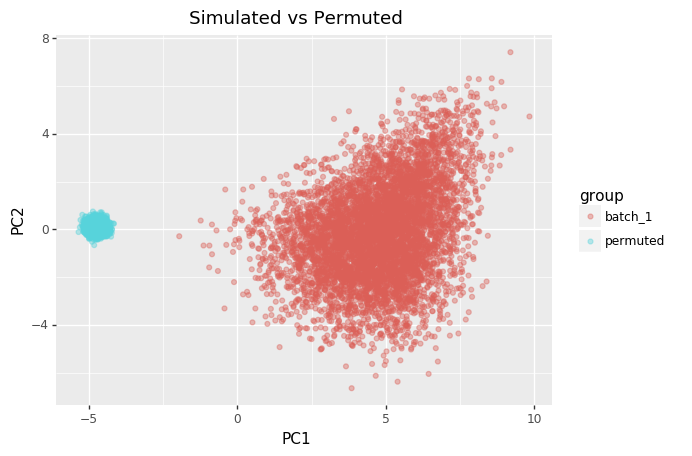

<ggplot: (8791241463272)>


In [9]:
# Plot permuted data
print(ggplot(shuffled_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
      + geom_point(aes(color='group'), alpha=0.4) \
      + xlab('PC1') \
      + ylab('PC2') \
      + ggtitle('Simulated vs Permuted')
     )